<h1>GE461 Project 4</h1>

<p>The World Health Organization (WHO) deﬁnes falls as involuntary events resulting in an
individual coming to rest at a lower level after initial impact. Falls pose a public health threat
across proad populations including the elderly, children, disabled individuals and patients
with orthopedic or neurological disorders. While external factors that raise potential for falls
might be controlled, it is often impossible to eliminate the intrinsic physiological factors. As
such, there is a pressing need for technology that reliably detects falls in real time to minimize
occurence of related injuries and healthcare costs. Wearable sensors oﬀer a promising avenue
in this regard by allowing unrestricted wireless monitoring of subject movements.
In this assignment, you will be analyzing wearable-sensor data from a group of subjects
performing either a fall action (F) or non-fall action (NF; i.e. basic motor activities of
daily living such as walking, standing, ascending, descending). Wearable-sensor data are
provided in the ﬁle falldetection_dataset.csv, which contains 566 samples of motor
actions along with respective action labels (’F’ or ’NF’) presented as rows. The 306 features
from the sensors that reﬂect various properties including velocity, acceleration, temperature
and pressure are presented as columns.</p>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import seaborn as sns

### Loading the Dataset

In [2]:
df = pd.read_csv('falldetection_dataset.csv',header=None)


In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,298,299,300,301,302,303,304,305,306,307
0,1,F,-1.444006,51.897025,9.051206,39.154050,4.861414,30.582530,26.361643,5.030885,...,0.106502,0.104355,0.101881,0.099105,0.096073,0.092818,0.089367,0.085755,0.082007,0.078169
1,2,F,-2.336273,35.644388,6.443654,24.827069,2.555905,14.351492,17.849532,10.018803,...,0.140290,0.136737,0.132445,0.127476,0.121855,0.115662,0.108960,0.101812,0.094281,0.086417
2,3,F,-3.160453,40.378218,6.126165,25.891205,3.261484,21.788334,16.620108,11.252057,...,0.160107,0.156836,0.153264,0.149447,0.145445,0.141263,0.136920,0.132413,0.127757,0.122951
3,4,F,-2.991333,44.093847,6.691918,28.082497,4.566522,31.905741,16.683106,6.005130,...,0.141562,0.138675,0.135498,0.132100,0.128517,0.124782,0.120944,0.116979,0.112901,0.108734
4,5,F,-3.079600,45.901880,6.674186,32.691078,4.156527,26.843041,21.150885,7.725367,...,0.178837,0.173142,0.166420,0.158743,0.150204,0.140860,0.130797,0.120147,0.108993,0.097428


In [4]:
# Droping the first column 
df = df.drop(columns=[0])
df.shape

(566, 307)

In [5]:
dataset_y = df[1]

dataset_x = df.drop(columns=[1])

In [6]:
dataset_y_changed = dataset_y.replace({"F":1,"NF":0})

/var/folders/th/2qxlqnss15b01gp33j9sym0r0000gn/T/ipykernel_33126/645748662.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset_y_changed = dataset_y.replace({"F":1,"NF":0})


In [7]:
dataset_x.shape

(566, 306)

# Part 1

<p>Exploratory data analysis via clustering can serve as an a priori step prior to targeted model
ﬁts. In this step, we would like to infer whether samples of sensor data form segregated clus-
ters in the space spanned by the sensor features. Since the number of features are relatively
large to visualize, ﬁrst perform principal components analysis (PCA) on the 566×306 fea-
ture matrix to extract the top two PCs, noting how much variance they capture. Using the
projections of 566 data samples onto the ﬁrst and second PCs, run k-means clustering (or
another method of choice) to separate data into clusters. Try diﬀerent numbers of clusters
(N), and state your assessment on a proper number of clusters. Taking the clusters obtained
when N=2, check the degree of percentage overlap/consistency between the cluster mem-
berships and the action labels originally provided. Comment on whether fall detection is
possible based on these measurements. </p>

### Applying PCA 

In [8]:
# Centering the data each column 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataset_x)

features_dataset_mean = dataset_x.mean(axis=0)
features_dataset_std = dataset_x.std(axis=0)
X_centered =( dataset_x - features_dataset_mean) / features_dataset_std


In [9]:
# Applying PCA 
hold = X_centered.shape[1]
pca = PCA(n_components=hold)
pca.fit(X_centered)

PCA(n_components=306)

Text(0.5, 1.0, 'Variance in Descending Order')

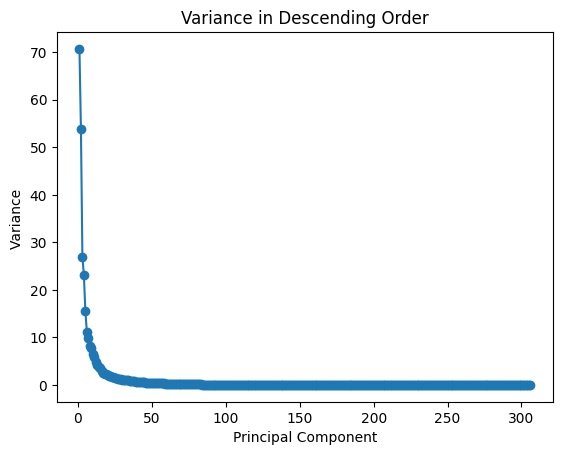

In [10]:
eigenvalues_pca = pca.explained_variance_

plt.figure()
plt.plot(range(1,hold+ 1), eigenvalues_pca,marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Variance ')
plt.title('Variance in Descending Order')

In [11]:
# Extract N =  2 
pca_kmeans = PCA(n_components=2)
pca_x = pca_kmeans.fit_transform(X_centered)

In [12]:
# how much variance do PC1 and PC2 
ratios = pca_kmeans.explained_variance_ratio_

print(f"PC1 explains {ratios[0] * 100:.2f}% of the total variance")
print(f"PC2 explains {ratios[1] * 100:.2f}% of the total variance")
print(f"Cumulative (PC1 + PC2): {ratios.sum() * 100:.2f}% of the total variance")

PC1 explains 23.10% of the total variance
PC2 explains 17.62% of the total variance
Cumulative (PC1 + PC2): 40.73% of the total variance


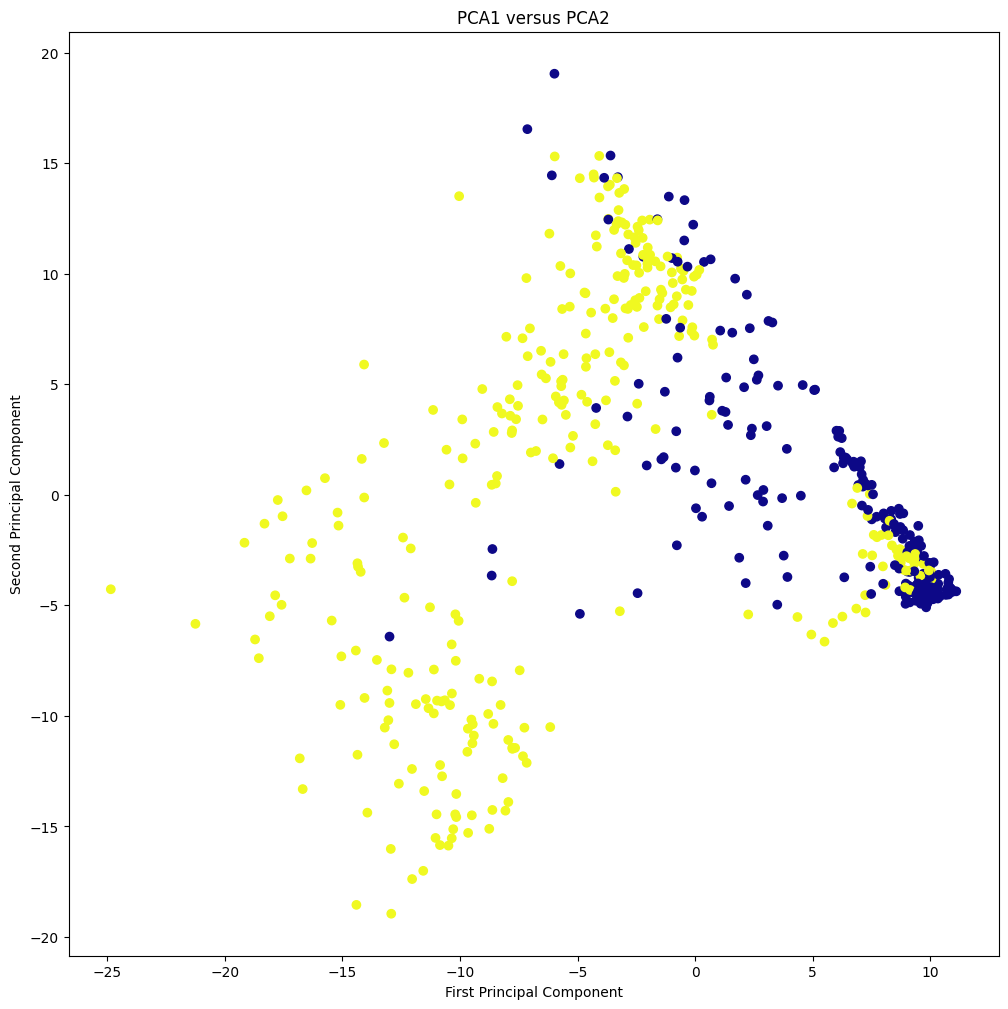

In [13]:
# giving a larger plot
plt.figure(figsize=(12, 12))

plt.scatter(pca_x[:, 0], pca_x[:, 1],
            c=dataset_y_changed,
            cmap='plasma')

# labeling x and y axes
plt.title("PCA1 versus PCA2")
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

### K- Means

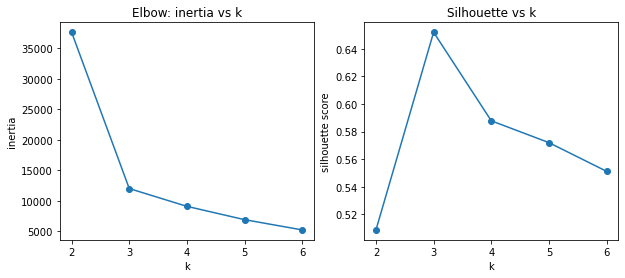

In [50]:
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertias = []
silhouettes = []
Ks = range(2, 7)

for k in Ks:
    km = KMeans(n_clusters=k, random_state=0).fit(pca_x)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(pca_x, km.labels_))

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(Ks, inertias, '-o');      ax[0].set(title="Elbow: inertia vs k", xlabel="k", ylabel="inertia")
ax[1].plot(Ks, silhouettes, '-o');  ax[1].set(title="Silhouette vs k", xlabel="k", ylabel="silhouette score")
plt.show()

In [64]:
# 1️⃣  Run k-means for exactly two clusters on the PCA data
km2   = KMeans(n_clusters=2, random_state=42, n_init=10)
cl2   = km2.fit_predict(pca_x)          # cluster memberships (0 or 1)
labels_true = dataset_y                         # your 'F' / 'NF' vector

# 2️⃣  Map each cluster ID to the label that is **most frequent** inside it
cluster_to_label = {}
for cid in np.unique(cl2):
    majority = pd.Series(labels_true[cl2 == cid]).mode()[0]
    cluster_to_label[cid] = majority

labels_pred = np.vectorize(cluster_to_label.get)(cl2)

# 3️⃣  Overall percentage overlap (plain accuracy)
overall_acc = accuracy_score(labels_true, labels_pred) * 100
print(f"Overall overlap = {overall_acc:.2f} %")

# 4️⃣  Detailed cross-tab / confusion matrix
cm = confusion_matrix(labels_true, labels_pred, labels=['F', 'NF'])
print("\nConfusion matrix (rows = true, cols = predicted):")
print(pd.DataFrame(cm, index=['F', 'NF'], columns=['F', 'NF']))

# 5️⃣  Per-cluster purity (optional)
for cid in np.unique(cl2):
    mask      = cl2 == cid
    purity    = (labels_true[mask] == labels_pred[mask]).mean() * 100
    print(f"Cluster {cid}: purity = {purity:.2f} % "
          f"({mask.sum()} samples, majority = '{cluster_to_label[cid]}')")

Overall overlap = 81.27 %

Confusion matrix (rows = true, cols = predicted):
      F   NF
F   266   47
NF   59  194
Cluster 0: purity = 81.85 % (325 samples, majority = 'F')
Cluster 1: purity = 80.50 % (241 samples, majority = 'NF')


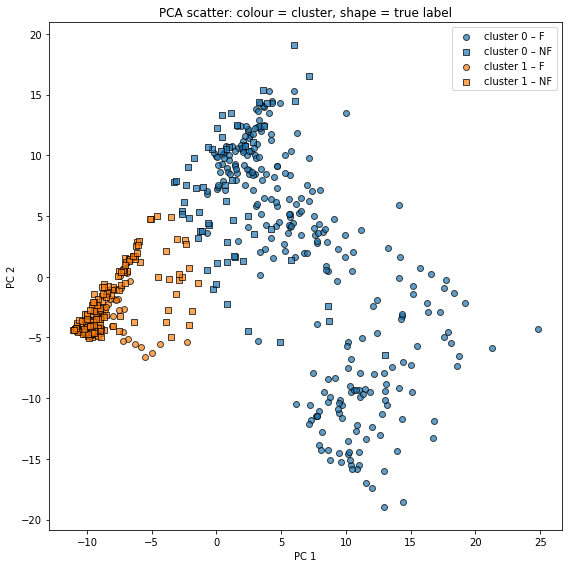

In [68]:
import matplotlib.pyplot as plt

# --- helper dictionaries ---
marker_dict = {'F': 'o', 'NF': 's'}   # fall = circle, non-fall = square
color_dict  = {0: 'C0', 1: 'C1'}      # cluster ID → colour

plt.figure(figsize=(8, 8))
for cid in np.unique(cl2):
    for lab in ['F', 'NF']:
        mask = (cl2 == cid) & (labels_true == lab)
        plt.scatter(pca_x[mask, 0], pca_x[mask, 1],
                    c=color_dict[cid],
                    marker=marker_dict[lab],
                    edgecolor='k', alpha=0.7,
                    label=f'cluster {cid} – {lab}')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA scatter: colour = cluster, shape = true label')
# de-duplicate identical legend entries
handles, labels = plt.gca().get_legend_handles_labels()
uniq = dict(zip(labels, handles))
plt.legend(uniq.values(), uniq.keys())
plt.tight_layout()
plt.show()

# Part 2

<p>Once the exploration is complete, we can proceed onto the supervised learning stage. In
this step, the goal is to build a classiﬁer that detects the action label (fall or non-fall) with
high accuracy. We will be testing two separate models for this purpose: a support-vector-
machine (SVM) classiﬁer and a multi-layer perceptron (MLP) classiﬁer. Freely experiment
with various hyperparameters included in these models to maximize classiﬁcation accuracy.
To do this, however, you need to implement a cross-validation procedure with a three-way
split of data into non-overlapping training/validation/testing sets (e.g., 70%, 15%,15%).
The models with various diﬀerent hyperparameters are ﬁt on the training set, the parameter
selection is performed based on the validation set, and the ﬁnal classiﬁcation accuracy is
reported on the testing set. Show/report all intermediate results, and comparatively evaluate
SVM and MLP models. Comment on the success of fall detection based on wearable sensors.</p>

### Splitting Train/Validation/Testing 

In [37]:
m = dataset_x.shape[0]
train_size = 0.7* m

validation_size = test_size = 0.15*m 


print("Train Size" ,train_size)
print("Validation Size" ,validation_size)
print("Test Size" ,test_size)


Train Size 396.2
Validation Size 84.89999999999999
Test Size 84.89999999999999


In [38]:
from sklearn.model_selection import train_test_split

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X_centered, dataset_y_changed, test_size=0.30, random_state=42, stratify=dataset_y_changed
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=22, stratify=y_tmp
)

print("Sizes:",  X_train.shape, X_val.shape, X_test.shape)


Sizes: (396, 306) (85, 306) (85, 306)


### Support Vector Machine  and Multi-Layer Classifier 

In [39]:
svm_param_grid = {
    'C':       [0.1, 1],
    'kernel':  ['rbf'],
    'gamma':   ['scale','auto']
}
mlp_param_grid = {
    'hidden_layer_sizes': [(2,), (10,)],
    'activation': ['logistic','relu'],
    'alpha':              [1e-4, 1e-3, 1e-2],
    'learning_rate_init': [1e-3, 1e-2],
    
}

In [40]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

def tune_model(ModelClass, param_grid, X_tr, y_tr, X_va, y_va):
    records = []
    for params in (dict(zip(param_grid, v)) for v in 
                   __import__('itertools').product(*param_grid.values())):
        model = ModelClass(**params, random_state=0)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_va)
        acc = accuracy_score(y_va, y_pred)
        records.append({**params, 'val_acc': acc})
    return pd.DataFrame.from_records(records)

# run tuning
svm_results = tune_model(SVC,  svm_param_grid, X_train, y_train, X_val, y_val)
mlp_results = tune_model(MLPClassifier, mlp_param_grid, X_train, y_train, X_val, y_val)

print("Top SVM configs:\n", svm_results.sort_values('val_acc', ascending=False).head())
print("Top MLP configs:\n", mlp_results.sort_values('val_acc', ascending=False))

/Users/mustafacankanbalci/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mustafacankanbalci/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mustafacankanbalci/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mustafacankanbalci/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv

Top SVM configs:
      C kernel  gamma   val_acc
2  1.0    rbf  scale  1.000000
3  1.0    rbf   auto  1.000000
0  0.1    rbf  scale  0.964706
1  0.1    rbf   auto  0.964706
Top MLP configs:
    hidden_layer_sizes activation   alpha  learning_rate_init   val_acc
0                (2,)   logistic  0.0001               0.001  1.000000
1                (2,)   logistic  0.0001               0.010  1.000000
22              (10,)       relu  0.0100               0.001  1.000000
21              (10,)       relu  0.0010               0.010  1.000000
20              (10,)       relu  0.0010               0.001  1.000000
19              (10,)       relu  0.0001               0.010  1.000000
18              (10,)       relu  0.0001               0.001  1.000000
17              (10,)   logistic  0.0100               0.010  1.000000
16              (10,)   logistic  0.0100               0.001  1.000000
15              (10,)   logistic  0.0010               0.010  1.000000
14              (10,)   logi

In [41]:
# pick the best rows
best_svm = svm_results.loc[svm_results['val_acc'].idxmax()].to_dict()
best_mlp = mlp_results.loc[mlp_results['val_acc'].idxmax()].to_dict()

# instantiate best models
best_svm_model = SVC(**{k:best_svm[k] for k in svm_param_grid}, random_state=0)
best_mlp_model = MLPClassifier(**{k:best_mlp[k] for k in mlp_param_grid}, random_state=0)

# (re)train on TRAIN only:
best_svm_model.fit(X_train, y_train)
best_mlp_model.fit(X_train, y_train)


for name, model in [('SVM', best_svm_model), ('MLP', best_mlp_model)]:
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {name} on TEST ===")
    print(f"Accuracy: {acc:.2%}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


=== SVM on TEST ===
Accuracy: 98.82%
Confusion Matrix:
 [[37  1]
 [ 0 47]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      1.00      0.99        47

    accuracy                           0.99        85
   macro avg       0.99      0.99      0.99        85
weighted avg       0.99      0.99      0.99        85


=== MLP on TEST ===
Accuracy: 100.00%
Confusion Matrix:
 [[38  0]
 [ 0 47]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        47

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



/Users/mustafacankanbalci/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [42]:
summary = pd.DataFrame([
    {'model':'SVM', 'val_acc': best_svm['val_acc'], 'test_acc': accuracy_score(y_test, best_svm_model.predict(X_test))},
    {'model':'MLP', 'val_acc': best_mlp['val_acc'], 'test_acc': accuracy_score(y_test, best_mlp_model.predict(X_test))}
])
print(summary)

  model  val_acc  test_acc
0   SVM      1.0  0.988235
1   MLP      1.0  1.000000
